# 1-  Comparison 1: Communication

## 1.1 - Sugarscape environment without communication

pygame 2.1.3 (SDL 2.0.22, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


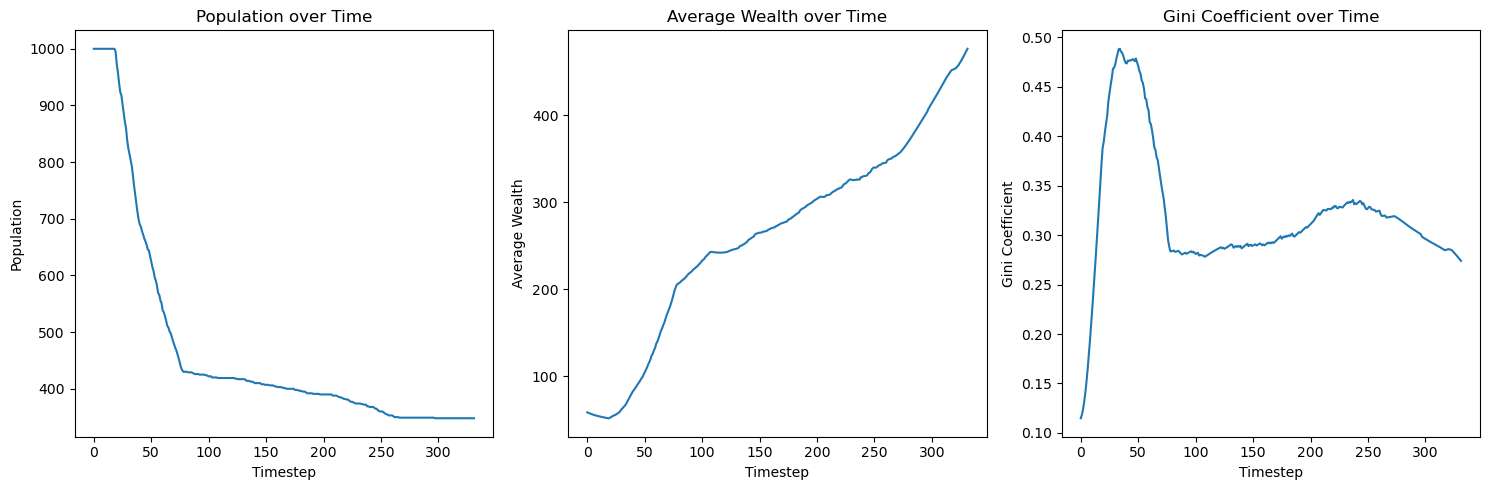

In [1]:
import random
import numpy as np
import pygame
import matplotlib.pyplot as plt

class SugarscapeEnvironment:
    def __init__(self, width, height, num_agents, cell_size=15, show_sugar_levels=True, seed=None):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.cell_size = cell_size
        self.show_sugar_levels = show_sugar_levels
        self.seed = seed  # Store the seed for reference

        # Initialize random number generators with the seed for reproducibility
        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.04,
            'sugar_peak_spread': 6,
            'job_center_duration': (40, 100)
        }

        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.max_sugar_landscape = self.sugar.copy()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []

        pygame.init()
        self.screen = pygame.display.set_mode((width * cell_size, height * cell_size))
        pygame.display.set_caption("Sugarscape Simulation - Limited Vision")
        self.clock = pygame.time.Clock()

        # Initialize font for rendering text
        self.font = pygame.font.Font(None, 10)  # You may need to adjust the font size

        self.population_history = []
        self.average_wealth_history = []
        self.gini_coefficient_history = []
        self.timestep = 0

    def create_initial_sugar_peaks(self, num_peaks=2):
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x, y = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x - center['x']) ** 2 + (y - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(-distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2))
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        # Round sugar levels to nearest integer
        self.sugar = np.round(self.sugar).astype(int)

    def initialize_agents(self):
        agents = []
        available_positions = set((x, y) for x in range(self.width) for y in range(self.height))
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    def create_agent(self, id, x, y):
        return {
            'id': id, 'x': x, 'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1,3),
        }

    def get_adjacent_cells(self, x, y):
        adjacent = [
            (x - 1, y), (x + 1, y),
            (x, y - 1), (x, y + 1),
        ]
        return [(x, y) for x, y in adjacent if 0 <= x < self.width and 0 <= y < self.height]

    def move_agent(self, agent):
        x, y = agent['x'], agent['y']
        adjacent_cells = self.get_adjacent_cells(x, y)

        best_cell = None
        best_sugar = -1

        for cell_x, cell_y in adjacent_cells:
            if (cell_x, cell_y) not in self.agent_positions:
                sugar_amount = self.sugar[cell_y, cell_x]
                if sugar_amount > best_sugar:
                    best_sugar = sugar_amount
                    best_cell = (cell_x, cell_y)

        if best_cell and best_sugar > 0:
            self.agent_positions.remove((agent['x'], agent['y']))
            agent['x'], agent['y'] = best_cell
            self.agent_positions.add((agent['x'], agent['y']))
        else:
            # Move randomly if no sugar is visible
            available_cells = [cell for cell in adjacent_cells if cell not in self.agent_positions]
            if available_cells:
                new_x, new_y = random.choice(available_cells)
                self.agent_positions.remove((agent['x'], agent['y']))
                agent['x'], agent['y'] = new_x, new_y
                self.agent_positions.add((agent['x'], agent['y']))
            # If no available cells, the agent stays put

    def step(self):
        # Update job centers
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Move agents
        for agent in self.agents:
            self.move_agent(agent)

        # Collect sugar and apply metabolism
        for agent in self.agents:
            collected_sugar = self.sugar[agent['y'], agent['x']]
            agent['sugar'] += collected_sugar
            self.sugar[agent['y'], agent['x']] = 0
            agent['sugar'] -= agent['metabolism']
            agent['sugar'] = int(agent['sugar'])  # Ensure agent sugar is also an integer

        # Handle agent death
        alive_agents = []
        for agent in self.agents:
            if agent['sugar'] <= 0:
                self.dead_agents.append({'x': agent['x'], 'y': agent['y'], 'death_time': self.timestep})
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        self.dead_agents = [agent for agent in self.dead_agents if self.timestep - agent['death_time'] <= 5]

        self.collect_data()
        self.timestep += 1

    def collect_data(self):
        population = len(self.agents)
        total_wealth = sum(agent['sugar'] for agent in self.agents)
        average_wealth = total_wealth / population if population > 0 else 0

        self.population_history.append(population)
        self.average_wealth_history.append(average_wealth)
        self.gini_coefficient_history.append(self.calculate_gini_coefficient())

    def calculate_gini_coefficient(self):
        if not self.agents:
            return 0
        wealth_values = sorted(agent['sugar'] for agent in self.agents)
        cumulative_wealth = np.cumsum(wealth_values)
        return (np.sum((2 * np.arange(1, len(wealth_values) + 1) - len(wealth_values) - 1) * wealth_values) /
                (len(wealth_values) * np.sum(wealth_values)))

    def render(self):
        self.screen.fill((255, 255, 255))

        for y in range(self.height):
            for x in range(self.width):
                sugar_level = self.sugar[y, x]
                color = self.get_color(sugar_level)
                pygame.draw.rect(self.screen, color,
                                 (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size))

                # Render sugar quantity as text if show_sugar_levels is True
                if self.show_sugar_levels:
                    sugar_text = self.font.render(f"{sugar_level}", True, (0, 0, 0))
                    text_rect = sugar_text.get_rect(center=(x * self.cell_size + self.cell_size // 2,
                                                            y * self.cell_size + self.cell_size // 2))
                    self.screen.blit(sugar_text, text_rect)

        for agent in self.agents:
            pygame.draw.circle(self.screen, (255, 0, 0),
                               (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                int(agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

        pygame.display.flip()

    def get_color(self, sugar_level):
        if sugar_level == 0:
            return (255, 255, 255)
        else:
            intensity = sugar_level / self.params['max_sugar']
            return (255, 255, int(255 * (1 - intensity)))

    def run_simulation(self, max_timesteps=1000):
        running = True
        while running and self.timestep < max_timesteps:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False

            self.step()
            self.render()
            self.clock.tick(50)

        self.plot_results()
        pygame.quit()

    def plot_results(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(self.population_history)
        plt.title('Population over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Population')

        plt.subplot(132)
        plt.plot(self.average_wealth_history)
        plt.title('Average Wealth over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Average Wealth')

        plt.subplot(133)
        plt.plot(self.gini_coefficient_history)
        plt.title('Gini Coefficient over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Gini Coefficient')

        plt.tight_layout()
        plt.show()


# Example usage with a fixed seed for reproducibility
if __name__ == "__main__":
    SEED = 23
    env = SugarscapeEnvironment(width=50, height=50, num_agents=1000, cell_size=10, show_sugar_levels=False, seed=SEED)
    env.run_simulation(max_timesteps=1000)


### Multiple runs

pygame 2.6.0 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
Starting baseline (Non-Communicative) simulations...
Running non-communicative simulation 1/20 with seed 0...
Running non-communicative simulation 2/20 with seed 1...
Running non-communicative simulation 3/20 with seed 2...
Running non-communicative simulation 4/20 with seed 3...
Running non-communicative simulation 5/20 with seed 4...
Running non-communicative simulation 6/20 with seed 5...
Running non-communicative simulation 7/20 with seed 6...
Running non-communicative simulation 8/20 with seed 7...
Running non-communicative simulation 9/20 with seed 8...
Running non-communicative simulation 10/20 with seed 9...
Running non-communicative simulation 11/20 with seed 10...
Running non-communicative simulation 12/20 with seed 11...
Running non-communicative simulation 13/20 with seed 12...
Running non-communicative simulation 14/20 with seed 13...
Running non-communicative s

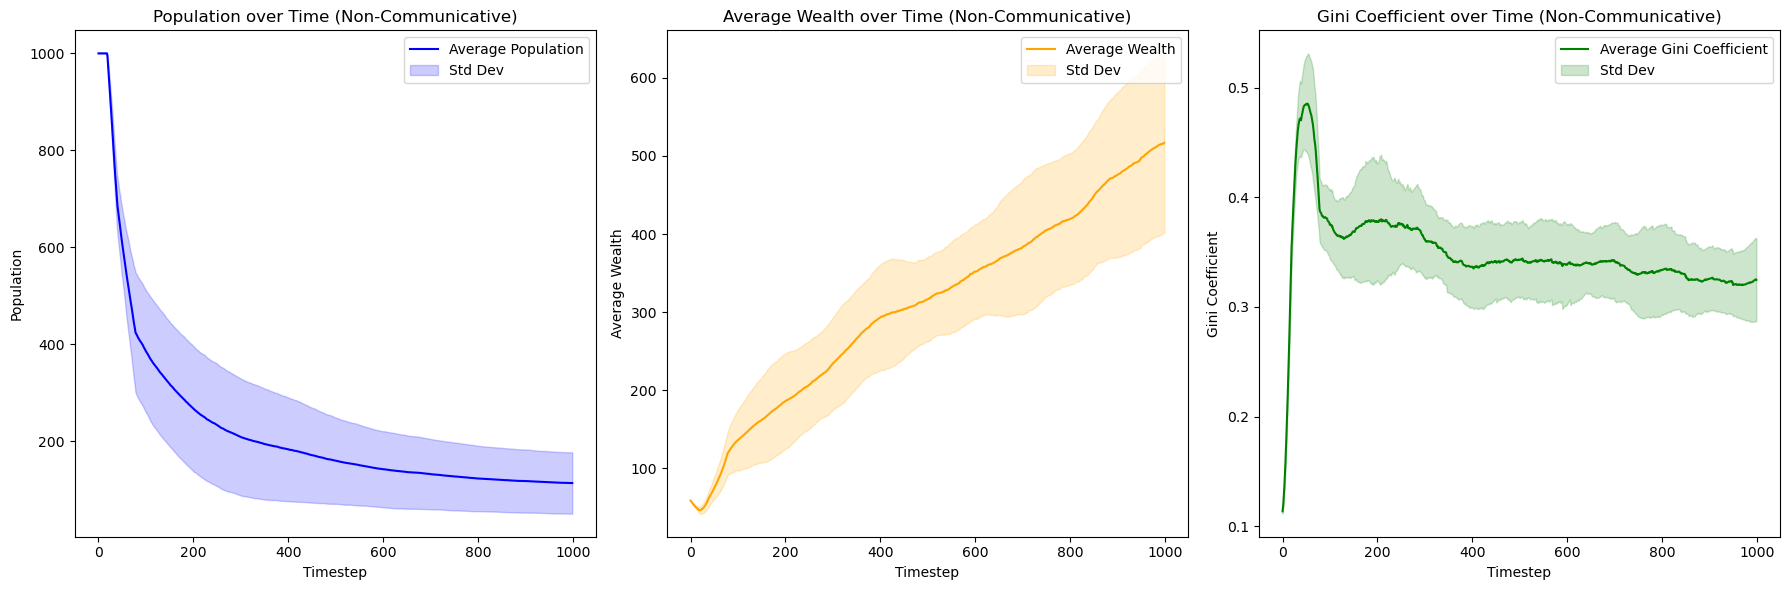


Non-Communicative simulations completed and results saved.


In [1]:
# non_communicative_model.py

import random
import numpy as np
import pygame
import matplotlib.pyplot as plt

class SugarscapeEnvironmentNonCommunicative:
    def __init__(self, width, height, num_agents, cell_size=15, show_sugar_levels=True, seed=None, visualize=False):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.cell_size = cell_size
        self.show_sugar_levels = show_sugar_levels
        self.seed = seed  # Store the seed for reference
        self.visualize = visualize

        # Initialize random number generators with the seed for reproducibility
        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.04,
            'sugar_peak_spread': 6,
            'job_center_duration': (40, 100),
            'exploration_probability': 0.1  # Added exploration probability
        }

        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []

        if self.visualize:
            pygame.init()
            self.screen = pygame.display.set_mode((width * cell_size, height * cell_size))
            pygame.display.set_caption("Sugarscape Simulation - Non-Communicative")
            self.clock = pygame.time.Clock()

            # Initialize font for rendering text
            self.font = pygame.font.Font(None, 10)  # You may need to adjust the font size

        self.population_history = []
        self.average_wealth_history = []
        self.gini_coefficient_history = []
        self.timestep = 0

    def create_initial_sugar_peaks(self, num_peaks=2):
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(-distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2))
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        # Round sugar levels to nearest integer
        self.sugar = np.round(self.sugar).astype(int)

    def initialize_agents(self):
        agents = []
        available_positions = set((x, y) for x in range(self.width) for y in range(self.height))
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    def create_agent(self, id, x, y):
        return {
            'id': id, 'x': x, 'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1,3),
        }

    def get_adjacent_cells(self, x, y):
        adjacent = [
            (x - 1, y), (x + 1, y),
            (x, y - 1), (x, y + 1),
        ]
        return [(x, y) for x, y in adjacent if 0 <= x < self.width and 0 <= y < self.height]

    def move_agent_probabilistic_exploration(self, agent):
        x, y = agent['x'], agent['y']
        adjacent_cells = self.get_adjacent_cells(x, y)

        # Filter out occupied cells
        available_cells = [cell for cell in adjacent_cells if cell not in self.agent_positions]

        if not available_cells:
            return  # No move possible

        epsilon = self.params['exploration_probability']
        if random.random() < epsilon:
            # Exploration: choose a random available cell
            chosen_cell = random.choice(available_cells)
        else:
            # Exploitation: choose based on sugar availability
            weights = [self.sugar[cell[1], cell[0]] + 1 for cell in available_cells]  # +1 to avoid zero weights
            total_weight = sum(weights)
            probabilities = [weight / total_weight for weight in weights]
            chosen_cell = random.choices(available_cells, weights=probabilities, k=1)[0]

        # Update agent position
        self.agent_positions.remove((x, y))
        agent['x'], agent['y'] = chosen_cell
        self.agent_positions.add(chosen_cell)

    def step(self):
        # Update job centers
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Move agents using probabilistic movement
        for agent in self.agents:
            self.move_agent_probabilistic_exploration(agent)

        # Collect sugar and apply metabolism
        for agent in self.agents:
            collected_sugar = self.sugar[agent['y'], agent['x']]
            agent['sugar'] += collected_sugar
            self.sugar[agent['y'], agent['x']] = 0
            agent['sugar'] -= agent['metabolism']
            agent['sugar'] = int(agent['sugar'])  # Ensure agent sugar is also an integer

        # Handle agent death
        alive_agents = []
        for agent in self.agents:
            if agent['sugar'] <= 0:
                self.dead_agents.append({'x': agent['x'], 'y': agent['y'], 'death_time': self.timestep})
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        self.dead_agents = [agent for agent in self.dead_agents if self.timestep - agent['death_time'] <= 5]

        self.collect_data()
        self.timestep += 1

    def collect_data(self):
        population = len(self.agents)
        total_wealth = sum(agent['sugar'] for agent in self.agents)
        average_wealth = total_wealth / population if population > 0 else 0

        self.population_history.append(population)
        self.average_wealth_history.append(average_wealth)
        self.gini_coefficient_history.append(self.calculate_gini_coefficient())

    def calculate_gini_coefficient(self):
        if not self.agents:
            return 0
        wealth_values = sorted(agent['sugar'] for agent in self.agents)
        cumulative_wealth = np.cumsum(wealth_values)
        return (np.sum((2 * np.arange(1, len(wealth_values) + 1) - len(wealth_values) - 1) * wealth_values) /
                (len(wealth_values) * np.sum(wealth_values)))

    def render(self):
        if not self.visualize:
            return
        self.screen.fill((255, 255, 255))

        for y in range(self.height):
            for x in range(self.width):
                sugar_level = self.sugar[y, x]
                color = self.get_color(sugar_level)
                pygame.draw.rect(self.screen, color,
                                 (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size))

                # Render sugar quantity as text if show_sugar_levels is True
                if self.show_sugar_levels:
                    sugar_text = self.font.render(f"{sugar_level}", True, (0, 0, 0))
                    text_rect = sugar_text.get_rect(center=(x * self.cell_size + self.cell_size // 2,
                                                            y * self.cell_size + self.cell_size // 2))
                    self.screen.blit(sugar_text, text_rect)

        for agent in self.agents:
            pygame.draw.circle(self.screen, (255, 0, 0),
                               (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                int(agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

        pygame.display.flip()

    def get_color(self, sugar_level):
        if sugar_level == 0:
            return (255, 255, 255)
        else:
            intensity = sugar_level / self.params['max_sugar']
            return (255, 255, int(255 * (1 - intensity)))

    def run_simulation(self, max_timesteps=1000):
        running = True
        while running and self.timestep < max_timesteps:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False

            self.step()
            self.render()
            if self.visualize:
                self.clock.tick(50)

        if self.visualize:
            self.plot_results()
            pygame.quit()

    def plot_results(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(self.population_history)
        plt.title('Population over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Population')

        plt.subplot(132)
        plt.plot(self.average_wealth_history)
        plt.title('Average Wealth over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Average Wealth')

        plt.subplot(133)
        plt.plot(self.gini_coefficient_history)
        plt.title('Gini Coefficient over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Gini Coefficient')

        plt.tight_layout()
        plt.show()


# Function to run multiple simulations and collect averaged results
def run_multiple_simulations_non_communicative(num_runs=20, width=50, height=50, num_agents=1000,
                                               cell_size=10, max_timesteps=1000):
    population_histories = []
    average_wealth_histories = []
    gini_coefficient_histories = []

    for run in range(num_runs):
        seed = run  # Different seed for each run
        env = SugarscapeEnvironmentNonCommunicative(width=width, height=height, num_agents=num_agents,
                                                    cell_size=cell_size, show_sugar_levels=False,
                                                    seed=seed, visualize=False)
        print(f"Running non-communicative simulation {run + 1}/{num_runs} with seed {seed}...")
        for _ in range(max_timesteps):
            env.step()
        population_histories.append(env.population_history)
        average_wealth_histories.append(env.average_wealth_history)
        gini_coefficient_histories.append(env.gini_coefficient_history)

    # Convert lists to NumPy arrays for statistical analysis
    population_histories = np.array(population_histories)
    average_wealth_histories = np.array(average_wealth_histories)
    gini_coefficient_histories = np.array(gini_coefficient_histories)

    # Calculate average and standard deviation
    avg_population = np.mean(population_histories, axis=0)
    std_population = np.std(population_histories, axis=0)

    avg_wealth = np.mean(average_wealth_histories, axis=0)
    std_wealth = np.std(average_wealth_histories, axis=0)

    avg_gini = np.mean(gini_coefficient_histories, axis=0)
    std_gini = np.std(gini_coefficient_histories, axis=0)

    # Plot averaged results with standard deviation
    plt.figure(figsize=(18, 6))

    plt.subplot(131)
    plt.plot(avg_population, label='Average Population', color='blue')
    plt.fill_between(range(max_timesteps), avg_population - std_population, avg_population + std_population,
                     color='blue', alpha=0.2, label='Std Dev')
    plt.title('Population over Time (Non-Communicative)')
    plt.xlabel('Timestep')
    plt.ylabel('Population')
    plt.legend()

    plt.subplot(132)
    plt.plot(avg_wealth, label='Average Wealth', color='orange')
    plt.fill_between(range(max_timesteps), avg_wealth - std_wealth, avg_wealth + std_wealth,
                     color='orange', alpha=0.2, label='Std Dev')
    plt.title('Average Wealth over Time (Non-Communicative)')
    plt.xlabel('Timestep')
    plt.ylabel('Average Wealth')
    plt.legend()

    plt.subplot(133)
    plt.plot(avg_gini, label='Average Gini Coefficient', color='green')
    plt.fill_between(range(max_timesteps), avg_gini - std_gini, avg_gini + std_gini,
                     color='green', alpha=0.2, label='Std Dev')
    plt.title('Gini Coefficient over Time (Non-Communicative)')
    plt.xlabel('Timestep')
    plt.ylabel('Gini Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return avg_population, std_population, avg_wealth, std_wealth, avg_gini, std_gini


if __name__ == "__main__":
    # Run baseline simulations
    print("Starting baseline (Non-Communicative) simulations...")
    baseline_avg_population, baseline_std_population, baseline_avg_wealth, baseline_std_wealth, baseline_avg_gini, baseline_std_gini = run_multiple_simulations_non_communicative(
        num_runs=20, width=50, height=50, num_agents=1000, cell_size=10, max_timesteps=1000)

    # Optionally, save the averaged results for further analysis
    np.save('baseline_avg_population.npy', baseline_avg_population)
    np.save('baseline_std_population.npy', baseline_std_population)
    np.save('baseline_avg_wealth.npy', baseline_avg_wealth)
    np.save('baseline_std_wealth.npy', baseline_std_wealth)
    np.save('baseline_avg_gini.npy', baseline_avg_gini)
    np.save('baseline_std_gini.npy', baseline_std_gini)

    print("\nNon-Communicative simulations completed and results saved.")


## 1.2 - Sugarscape Simulation with Communication

### visualisation of one simulation

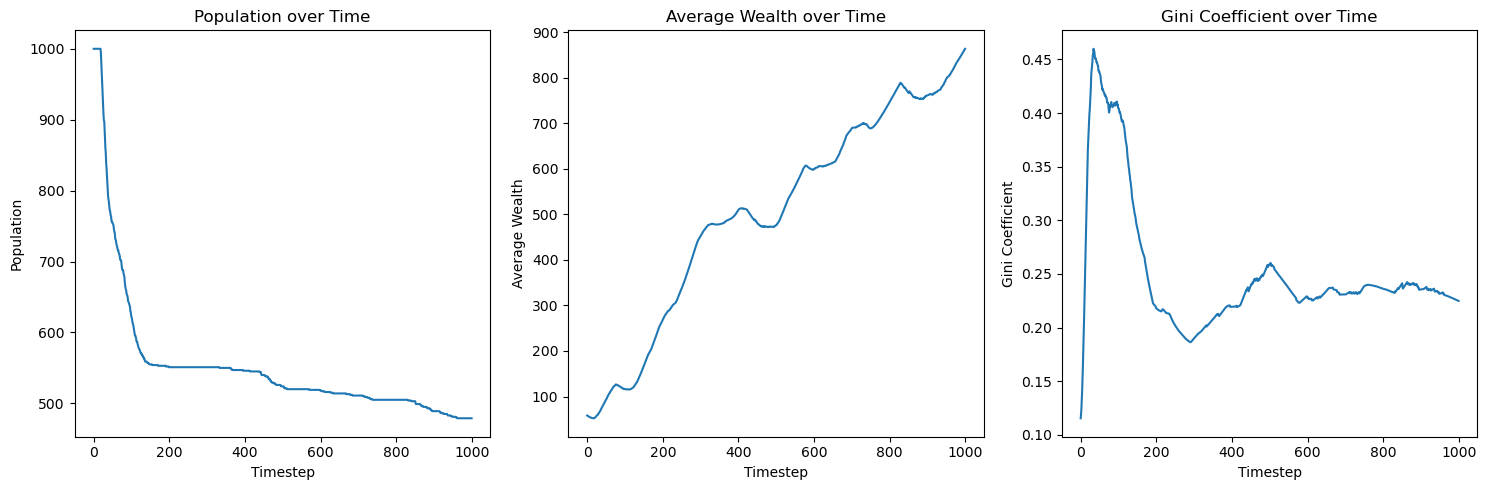

In [7]:
import random
import numpy as np
import pygame
import matplotlib.pyplot as plt
from collections import deque
from scipy.spatial import cKDTree  # Import cKDTree for spatial indexing

class SugarscapeEnvironment:
    def __init__(self, width, height, num_agents, cell_size=10, show_sugar_levels=True,
                 show_broadcast_radius=True, show_agent_paths=True, broadcast_radius=5, seed=None):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.cell_size = cell_size
        self.show_sugar_levels = show_sugar_levels
        self.show_broadcast_radius = show_broadcast_radius
        self.show_agent_paths = show_agent_paths
        self.broadcast_radius = broadcast_radius
        self.seed = seed  # Store the seed for reference

        # Initialize random number generators with the seed for reproducibility
        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.04,
            'sugar_peak_spread': 6,
            'job_center_duration': (40, 100),
            'vision_range': 1,
            'message_expiry': 15,
            'max_relay_messages': 10
        }

        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.max_sugar_landscape = self.sugar.copy()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []

        pygame.init()
        self.screen = pygame.display.set_mode((width * cell_size, height * cell_size))
        pygame.display.set_caption("Sugarscape Simulation - With Broadcasting")
        self.clock = pygame.time.Clock()

        self.font = pygame.font.Font(None, 10)

        self.population_history = []
        self.average_wealth_history = []
        self.gini_coefficient_history = []
        self.timestep = 0

    def create_initial_sugar_peaks(self, num_peaks=2):
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x, y = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x - center['x']) ** 2 + (y - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(-distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2))
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        self.sugar = np.round(self.sugar).astype(int)

    def initialize_agents(self):
        agents = []
        available_positions = set((x, y) for x in range(self.width) for y in range(self.height))
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    def create_agent(self, id, x, y):
        return {
            'id': id,
            'x': x,
            'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1, 3),
            'vision': self.params['vision_range'],
            'broadcast_radius': max(1, int(np.random.normal(self.broadcast_radius, self.broadcast_radius / 3))),
            'messages': deque(maxlen=100),
            'destination': None
        }

    def get_adjacent_cells(self, x, y):
        adjacent = [
            (x - 1, y), (x + 1, y),
            (x, y - 1), (x, y + 1),
        ]
        return [(x, y) for x, y in adjacent if 0 <= x < self.width and 0 <= y < self.height]

    def get_visible_sugar(self, agent):
        x, y = agent['x'], agent['y']
        vision = agent['vision']
        visible_area = self.sugar[max(0, y - vision):min(self.height, y + vision + 1),
                       max(0, x - vision):min(self.width, x + vision + 1)]
        return visible_area

    def broadcast_messages(self):
        if not self.agents:
            return  # No agents to broadcast

        # Extract agent positions
        positions = np.array([[agent['x'], agent['y']] for agent in self.agents])

        # Build cKDTree for efficient spatial queries
        tree = cKDTree(positions)

        # Query all neighbors within broadcast_radius for each agent
        all_neighbors = tree.query_ball_point(positions, self.broadcast_radius)

        for i, agent in enumerate(self.agents):
            # Create the message from this agent
            visible_sugar = self.get_visible_sugar(agent).sum()
            message = {
                'sender_id': agent['id'],
                'sugar_amount': visible_sugar,
                'timestep': self.timestep,
                'x': agent['x'],
                'y': agent['y']
            }

            neighbors = all_neighbors[i]
            for neighbor_idx in neighbors:
                if neighbor_idx != i:
                    self.agents[neighbor_idx]['messages'].append(message)

    def move_agent(self, agent):
        x, y = agent['x'], agent['y']

        # Check messages for better locations
        best_message = max(agent['messages'], key=lambda m: m['sugar_amount'], default=None)
        if best_message and best_message['sugar_amount'] > self.get_visible_sugar(agent).sum():
            agent['destination'] = (best_message['x'], best_message['y'])
        else:
            agent['destination'] = None

        possible_moves = []
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]:
            new_x, new_y = x + dx, y + dy
            if 0 <= new_x < self.width and 0 <= new_y < self.height and (new_x, new_y) not in self.agent_positions:
                sugar_amount = self.sugar[new_y, new_x]
                # To optimize, precompute a minimum distance from others
                # Using a generator expression is still costly; consider alternatives if needed
                distance_from_others = min(
                    (abs(new_x - a['x']) + abs(new_y - a['y']) for a in self.agents if a != agent), default=0)
                possible_moves.append((new_x, new_y, sugar_amount, distance_from_others))

        if not possible_moves:
            return  # No valid moves available

        # Add exploration chance
        if random.random() < 0.1:  # 10% chance to make a random move
            new_x, new_y, _, _ = random.choice(possible_moves)
        else:
            if agent['destination']:
                # Move towards the destination
                dest_x, dest_y = agent['destination']
                possible_moves.sort(
                    key=lambda m: abs(m[0] - dest_x) + abs(m[1] - dest_y) - 0.1 * m[3])
            else:
                # Move to the best sugar patch
                possible_moves.sort(key=lambda m: m[2] + 0.1 * m[3], reverse=True)

            # Choose randomly from the top 3 best moves (or all if less than 3)
            best_moves = possible_moves[:min(3, len(possible_moves))]
            new_x, new_y, _, _ = random.choice(best_moves)

        # Update agent position
        self.agent_positions.remove((agent['x'], agent['y']))
        agent['x'], agent['y'] = new_x, new_y
        self.agent_positions.add((new_x, new_y))

        if agent['destination'] and (new_x, new_y) == agent['destination']:
            agent['destination'] = None

    def step(self):
        # Update job centers
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Move agents
        for agent in self.agents:
            self.move_agent(agent)

        # Collect sugar and apply metabolism
        for agent in self.agents:
            collected_sugar = self.sugar[agent['y'], agent['x']]
            agent['sugar'] += collected_sugar
            self.sugar[agent['y'], agent['x']] = 0
            agent['sugar'] -= agent['metabolism']
            agent['sugar'] = int(agent['sugar'])  # Ensure agent sugar is also an integer

        # Broadcast messages efficiently
        self.broadcast_messages()

        # Clean up expired messages
        for agent in self.agents:
            agent['messages'] = deque(
                [msg for msg in agent['messages'] if self.timestep - msg['timestep'] <= self.params['message_expiry']],
                maxlen=100)

        # Handle agent death
        alive_agents = []
        for agent in self.agents:
            if agent['sugar'] <= 0:
                self.dead_agents.append({'x': agent['x'], 'y': agent['y'], 'death_time': self.timestep})
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        self.dead_agents = [agent for agent in self.dead_agents if self.timestep - agent['death_time'] <= 5]

        self.collect_data()
        self.timestep += 1

    def render(self):
        self.screen.fill((255, 255, 255))

        for y in range(self.height):
            for x in range(self.width):
                sugar_level = self.sugar[y, x]
                color = self.get_color(sugar_level)
                pygame.draw.rect(self.screen, color,
                                 (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size))

                if self.show_sugar_levels:
                    sugar_text = self.font.render(f"{sugar_level}", True, (0, 0, 0))
                    text_rect = sugar_text.get_rect(center=(x * self.cell_size + self.cell_size // 2,
                                                            y * self.cell_size + self.cell_size // 2))
                    self.screen.blit(sugar_text, text_rect)

        for dead_agent in self.dead_agents:
            pygame.draw.circle(self.screen, (128, 128, 128),
                               (int(dead_agent['x'] * self.cell_size + self.cell_size / 2),
                                int(dead_agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

        for agent in self.agents:
            if self.show_broadcast_radius:
                pygame.draw.circle(self.screen, (200, 200, 200),
                                   (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                    int(agent['y'] * self.cell_size + self.cell_size / 2)),
                                   int(agent['broadcast_radius'] * self.cell_size), 1)

            pygame.draw.circle(self.screen, (255, 0, 0),
                               (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                int(agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

            if self.show_agent_paths and agent['destination']:
                pygame.draw.line(self.screen, (0, 255, 0),
                                 (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                  int(agent['y'] * self.cell_size + self.cell_size / 2)),
                                 (int(agent['destination'][0] * self.cell_size + self.cell_size / 2),
                                  int(agent['destination'][1] * self.cell_size + self.cell_size / 2)),
                                 1)

        pygame.display.flip()

    def get_color(self, sugar_level):
        if sugar_level == 0:
            return (255, 255, 255)
        else:
            intensity = sugar_level / self.params['max_sugar']
            return (255, 255, int(255 * (1 - intensity)))

    def collect_data(self):
        population = len(self.agents)
        total_wealth = sum(agent['sugar'] for agent in self.agents)
        average_wealth = total_wealth / population if population > 0 else 0

        self.population_history.append(population)
        self.average_wealth_history.append(average_wealth)
        self.gini_coefficient_history.append(self.calculate_gini_coefficient())

    def calculate_gini_coefficient(self):
        if not self.agents:
            return 0
        wealth_values = sorted(agent['sugar'] for agent in self.agents)
        cumulative_wealth = np.cumsum(wealth_values)
        return (np.sum((2 * np.arange(1, len(wealth_values) + 1) - len(wealth_values) - 1) * wealth_values) /
                (len(wealth_values) * np.sum(wealth_values)))

    def plot_results(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(self.population_history)
        plt.title('Population over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Population')

        plt.subplot(132)
        plt.plot(self.average_wealth_history)
        plt.title('Average Wealth over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Average Wealth')

        plt.subplot(133)
        plt.plot(self.gini_coefficient_history)
        plt.title('Gini Coefficient over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Gini Coefficient')

        plt.tight_layout()
        plt.show()

    def run_simulation(self, max_timesteps=1000):
        running = True
        while running and self.timestep < max_timesteps:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False

            self.step()
            self.render()
            self.clock.tick(5)  # Adjust simulation speed as needed

        self.plot_results()
        pygame.quit()

# Example usage with a fixed seed for reproducibility
if __name__ == "__main__":
    SEED = 23  # You can choose any integer value for the seed
    env = SugarscapeEnvironment(width=50, height=50, num_agents=1000, cell_size=10,
                                broadcast_radius=15,
                                show_sugar_levels=False,
                                show_broadcast_radius=False,
                                show_agent_paths=True,
                                seed=SEED)
    env.run_simulation(max_timesteps=1000)


### Multiple simulations

Starting communicative simulations...
Running communicative simulation 1/20 with seed 0...
Running communicative simulation 2/20 with seed 1...
Running communicative simulation 3/20 with seed 2...
Running communicative simulation 4/20 with seed 3...
Running communicative simulation 5/20 with seed 4...
Running communicative simulation 6/20 with seed 5...
Running communicative simulation 7/20 with seed 6...
Running communicative simulation 8/20 with seed 7...
Running communicative simulation 9/20 with seed 8...
Running communicative simulation 10/20 with seed 9...
Running communicative simulation 11/20 with seed 10...
Running communicative simulation 12/20 with seed 11...
Running communicative simulation 13/20 with seed 12...
Running communicative simulation 14/20 with seed 13...
Running communicative simulation 15/20 with seed 14...
Running communicative simulation 16/20 with seed 15...
Running communicative simulation 17/20 with seed 16...
Running communicative simulation 18/20 with se

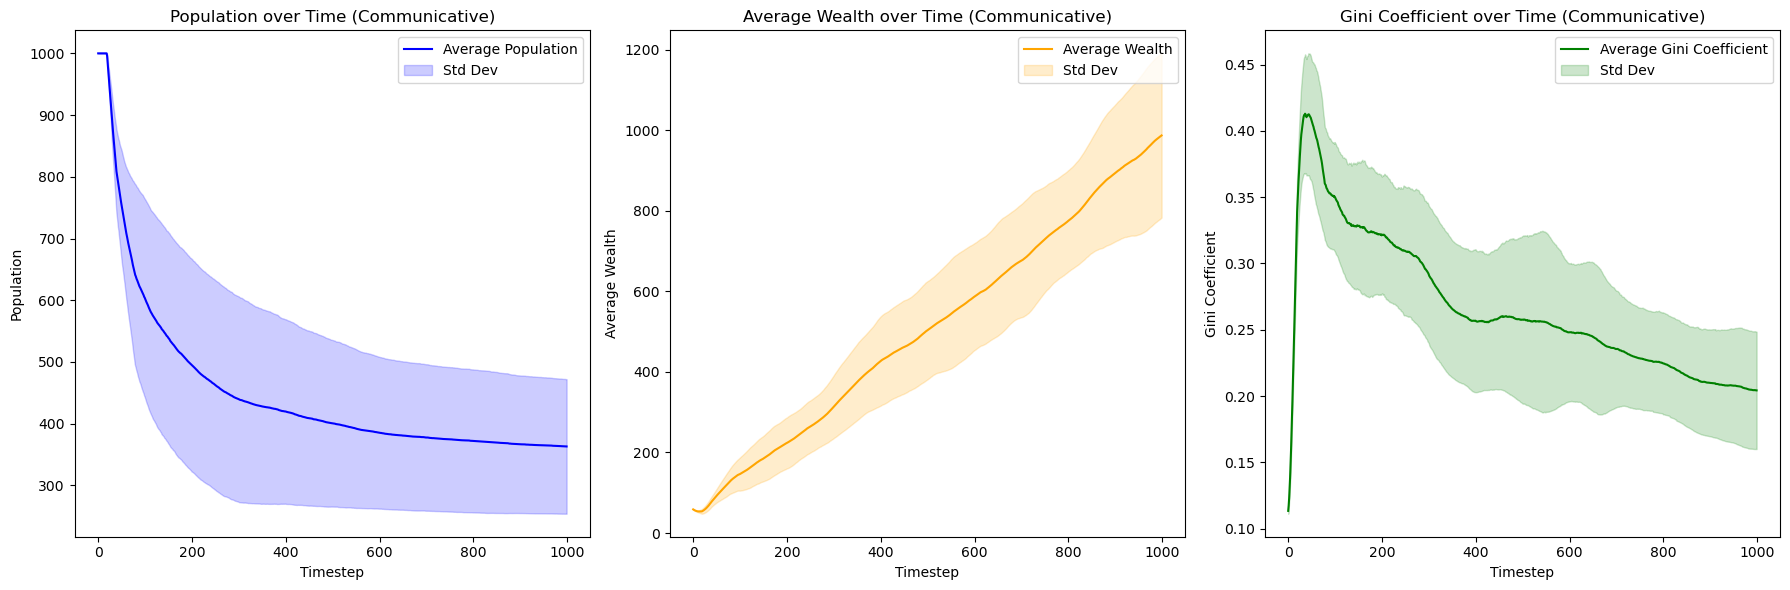


Communicative simulations completed and results saved.


In [2]:
# communicative_model.py

import random
import numpy as np
import pygame
import matplotlib.pyplot as plt
from collections import deque
from scipy.spatial import cKDTree  # Import cKDTree for spatial indexing

class SugarscapeEnvironmentCommunicative:
    def __init__(self, width, height, num_agents, cell_size=10, show_sugar_levels=True,
                 broadcast_radius=10, seed=None, visualize=False):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.cell_size = cell_size
        self.show_sugar_levels = show_sugar_levels
        self.broadcast_radius = broadcast_radius  # Increased broadcast radius
        self.seed = seed  # Store the seed for reference
        self.visualize = visualize

        # Initialize random number generators with the seed for reproducibility
        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.04,
            'sugar_peak_spread': 6,
            'job_center_duration': (40, 100),
            'vision_range': 2,  # Increased vision range
            'message_expiry': 30,  # Extended message expiry
            'max_messages': 50,  # Limit messages per agent
            'exploration_probability': 0.1
        }

        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []

        if self.visualize:
            pygame.init()
            self.screen = pygame.display.set_mode((width * cell_size, height * cell_size))
            pygame.display.set_caption("Sugarscape Simulation - Communicative")
            self.clock = pygame.time.Clock()

            self.font = pygame.font.Font(None, 10)

        self.population_history = []
        self.average_wealth_history = []
        self.gini_coefficient_history = []
        self.timestep = 0

    def create_initial_sugar_peaks(self, num_peaks=2):
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(-distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2))
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        self.sugar = np.round(self.sugar).astype(int)

    def initialize_agents(self):
        agents = []
        available_positions = set((x, y) for x in range(self.width) for y in range(self.height))
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    def create_agent(self, id, x, y):
        return {
            'id': id,
            'x': x,
            'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1, 3),
            'vision': self.params['vision_range'],
            'broadcast_radius': self.broadcast_radius,
            'messages': deque(maxlen=self.params['max_messages']),
            'destination': None,
            'memory': deque(maxlen=10)  # Memory of past successful locations
        }

    def get_adjacent_cells(self, x, y):
        adjacent = [
            (x - 1, y), (x + 1, y),
            (x, y - 1), (x, y + 1),
        ]
        return [(x, y) for x, y in adjacent if 0 <= x < self.width and 0 <= y < self.height]

    def get_visible_sugar(self, agent):
        x, y = agent['x'], agent['y']
        vision = agent['vision']
        y_min = max(0, y - vision)
        y_max = min(self.height, y + vision + 1)
        x_min = max(0, x - vision)
        x_max = min(self.width, x + vision + 1)
        visible_area = self.sugar[y_min:y_max, x_min:x_max]
        return visible_area

    def broadcast_messages(self):
        if not self.agents:
            return  # No agents to broadcast

        positions = np.array([[agent['x'], agent['y']] for agent in self.agents])
        tree = cKDTree(positions)
        all_neighbors = tree.query_ball_point(positions, self.broadcast_radius)

        for i, agent in enumerate(self.agents):
            # Identify visible sugar peaks
            visible_sugar = self.get_visible_sugar(agent)
            sugar_locations = np.argwhere(visible_sugar > 0)
            messages = []
            for loc in sugar_locations:
                msg = {
                    'sender_id': agent['id'],
                    'timestep': self.timestep,
                    'sugar_amount': visible_sugar[loc[0], loc[1]],
                    'x': agent['x'] + loc[1] - agent['vision'],
                    'y': agent['y'] + loc[0] - agent['vision']
                }
                messages.append(msg)

            neighbors = all_neighbors[i]
            for neighbor_idx in neighbors:
                if neighbor_idx != i:
                    for msg in messages:
                        self.agents[neighbor_idx]['messages'].append(msg)

    def move_agent(self, agent):
        x, y = agent['x'], agent['y']

        # Filter valid messages
        valid_messages = [msg for msg in agent['messages'] if self.timestep - msg['timestep'] <= self.params['message_expiry']]
        if valid_messages:
            # Prioritize messages
            valid_messages.sort(key=lambda m: (m['sugar_amount'], -abs(agent['x'] - m['x']) - abs(agent['y'] - m['y']), -m['timestep']), reverse=True)
            best_message = valid_messages[0]
            agent['destination'] = (best_message['x'], best_message['y'])
        else:
            agent['destination'] = None

        # Proceed with movement towards destination or local exploration
        self.move_towards_destination(agent)

    def move_towards_destination(self, agent):
        x, y = agent['x'], agent['y']
        possible_moves = self.get_adjacent_cells(x, y)
        available_moves = [cell for cell in possible_moves if cell not in self.agent_positions]

        if not available_moves:
            return  # No moves available

        if agent['destination']:
            dest_x, dest_y = agent['destination']
            # Calculate move that brings agent closer to the destination
            available_moves.sort(key=lambda cell: abs(cell[0] - dest_x) + abs(cell[1] - dest_y))
            chosen_move = available_moves[0]
        else:
            # Exploration with preference for higher sugar
            epsilon = self.params['exploration_probability']
            if random.random() < epsilon:
                # Random exploration
                chosen_move = random.choice(available_moves)
            else:
                # Prefer higher sugar
                weights = [self.sugar[cell[1], cell[0]] + 1 for cell in available_moves]
                total_weight = sum(weights)
                probabilities = [w / total_weight for w in weights]
                chosen_move = random.choices(available_moves, weights=probabilities, k=1)[0]

        # Update agent position
        self.agent_positions.remove((x, y))
        agent['x'], agent['y'] = chosen_move
        self.agent_positions.add(chosen_move)

        # Check if destination reached
        if agent['destination'] == (agent['x'], agent['y']):
            agent['destination'] = None

    def collect_sugar_and_update_memory(self, agent):
        collected_sugar = self.sugar[agent['y'], agent['x']]
        if collected_sugar > 0:
            agent['memory'].append((agent['x'], agent['y'], collected_sugar))
        agent['sugar'] += collected_sugar
        self.sugar[agent['y'], agent['x']] = 0
        agent['sugar'] -= agent['metabolism']
        agent['sugar'] = int(agent['sugar'])  # Ensure agent sugar is also an integer

    def step(self):
        # Update job centers
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Move agents
        for agent in self.agents:
            self.move_agent(agent)

        # Collect sugar and apply metabolism
        for agent in self.agents:
            self.collect_sugar_and_update_memory(agent)

        # Broadcast messages efficiently
        self.broadcast_messages()

        # Clean up expired messages
        for agent in self.agents:
            agent['messages'] = deque(
                [msg for msg in agent['messages'] if self.timestep - msg['timestep'] <= self.params['message_expiry']],
                maxlen=self.params['max_messages']
            )

        # Handle agent death
        alive_agents = []
        for agent in self.agents:
            if agent['sugar'] <= 0:
                self.dead_agents.append({'x': agent['x'], 'y': agent['y'], 'death_time': self.timestep})
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        self.dead_agents = [agent for agent in self.dead_agents if self.timestep - agent['death_time'] <= 5]

        self.collect_data()
        self.timestep += 1

    def collect_data(self):
        population = len(self.agents)
        total_wealth = sum(agent['sugar'] for agent in self.agents)
        average_wealth = total_wealth / population if population > 0 else 0

        self.population_history.append(population)
        self.average_wealth_history.append(average_wealth)
        self.gini_coefficient_history.append(self.calculate_gini_coefficient())

    def calculate_gini_coefficient(self):
        if not self.agents:
            return 0
        wealth_values = sorted(agent['sugar'] for agent in self.agents)
        cumulative_wealth = np.cumsum(wealth_values)
        return (np.sum((2 * np.arange(1, len(wealth_values) + 1) - len(wealth_values) - 1) * wealth_values) /
                (len(wealth_values) * np.sum(wealth_values)))

    def render(self):
        if not self.visualize:
            return
        self.screen.fill((255, 255, 255))

        for y in range(self.height):
            for x in range(self.width):
                sugar_level = self.sugar[y, x]
                color = self.get_color(sugar_level)
                pygame.draw.rect(self.screen, color,
                                 (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size))

                if self.show_sugar_levels:
                    sugar_text = self.font.render(f"{sugar_level}", True, (0, 0, 0))
                    text_rect = sugar_text.get_rect(center=(x * self.cell_size + self.cell_size // 2,
                                                            y * self.cell_size + self.cell_size // 2))
                    self.screen.blit(sugar_text, text_rect)

        for agent in self.agents:
            pygame.draw.circle(self.screen, (255, 0, 0),
                               (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                int(agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

        pygame.display.flip()

    def get_color(self, sugar_level):
        if sugar_level == 0:
            return (255, 255, 255)
        else:
            intensity = sugar_level / self.params['max_sugar']
            return (255, 255, int(255 * (1 - intensity)))

    def run_simulation(self, max_timesteps=1000):
        running = True
        while running and self.timestep < max_timesteps:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False

            self.step()
            self.render()
            if self.visualize:
                self.clock.tick(5)  # Adjust simulation speed as needed

        if self.visualize:
            self.plot_results()
            pygame.quit()

    def plot_results(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(self.population_history)
        plt.title('Population over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Population')

        plt.subplot(132)
        plt.plot(self.average_wealth_history)
        plt.title('Average Wealth over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Average Wealth')

        plt.subplot(133)
        plt.plot(self.gini_coefficient_history)
        plt.title('Gini Coefficient over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Gini Coefficient')

        plt.tight_layout()
        plt.show()


# Function to run multiple simulations and collect averaged results
def run_multiple_simulations_communicative(num_runs=20, width=50, height=50, num_agents=1000,
                                           cell_size=10, broadcast_radius=10, max_timesteps=1000):
    population_histories = []
    average_wealth_histories = []
    gini_coefficient_histories = []

    for run in range(num_runs):
        seed = run  # Different seed for each run
        env = SugarscapeEnvironmentCommunicative(width=width, height=height, num_agents=num_agents,
                                                 cell_size=cell_size, show_sugar_levels=False,
                                                 broadcast_radius=broadcast_radius, seed=seed, visualize=False)
        print(f"Running communicative simulation {run + 1}/{num_runs} with seed {seed}...")
        for _ in range(max_timesteps):
            env.step()
        population_histories.append(env.population_history)
        average_wealth_histories.append(env.average_wealth_history)
        gini_coefficient_histories.append(env.gini_coefficient_history)

    # Convert lists to NumPy arrays for statistical analysis
    population_histories = np.array(population_histories)
    average_wealth_histories = np.array(average_wealth_histories)
    gini_coefficient_histories = np.array(gini_coefficient_histories)

    # Calculate average and standard deviation
    avg_population = np.mean(population_histories, axis=0)
    std_population = np.std(population_histories, axis=0)

    avg_wealth = np.mean(average_wealth_histories, axis=0)
    std_wealth = np.std(average_wealth_histories, axis=0)

    avg_gini = np.mean(gini_coefficient_histories, axis=0)
    std_gini = np.std(gini_coefficient_histories, axis=0)

    # Plot averaged results with standard deviation
    plt.figure(figsize=(18, 6))

    plt.subplot(131)
    plt.plot(avg_population, label='Average Population', color='blue')
    plt.fill_between(range(max_timesteps), avg_population - std_population, avg_population + std_population,
                     color='blue', alpha=0.2, label='Std Dev')
    plt.title('Population over Time (Communicative)')
    plt.xlabel('Timestep')
    plt.ylabel('Population')
    plt.legend()

    plt.subplot(132)
    plt.plot(avg_wealth, label='Average Wealth', color='orange')
    plt.fill_between(range(max_timesteps), avg_wealth - std_wealth, avg_wealth + std_wealth,
                     color='orange', alpha=0.2, label='Std Dev')
    plt.title('Average Wealth over Time (Communicative)')
    plt.xlabel('Timestep')
    plt.ylabel('Average Wealth')
    plt.legend()

    plt.subplot(133)
    plt.plot(avg_gini, label='Average Gini Coefficient', color='green')
    plt.fill_between(range(max_timesteps), avg_gini - std_gini, avg_gini + std_gini,
                     color='green', alpha=0.2, label='Std Dev')
    plt.title('Gini Coefficient over Time (Communicative)')
    plt.xlabel('Timestep')
    plt.ylabel('Gini Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return avg_population, std_population, avg_wealth, std_wealth, avg_gini, std_gini


if __name__ == "__main__":
    # Run communicative simulations
    print("Starting communicative simulations...")
    communicative_avg_population, communicative_std_population, communicative_avg_wealth, communicative_std_wealth, communicative_avg_gini, communicative_std_gini = run_multiple_simulations_communicative(
        num_runs=20, width=50, height=50, num_agents=1000, cell_size=10, broadcast_radius=10, max_timesteps=1000)

    # # Optionally, save the averaged results for further analysis
    # np.save('communicative_avg_population.npy', communicative_avg_population)
    # np.save('communicative_std_population.npy', communicative_std_population)
    # np.save('communicative_avg_wealth.npy', communicative_avg_wealth)
    # np.save('communicative_std_wealth.npy', communicative_std_wealth)
    # np.save('communicative_avg_gini.npy', communicative_avg_gini)
    # np.save('communicative_std_gini.npy', communicative_std_gini)

    print("\nCommunicative simulations completed and results saved.")


# 2- Rural vs Urban

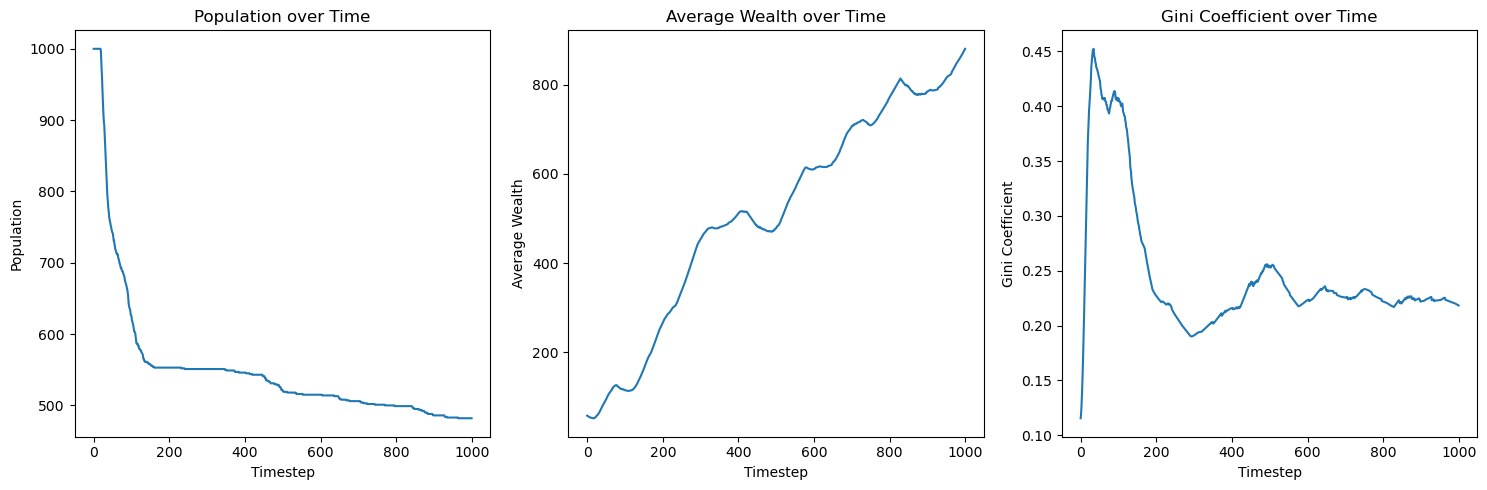

In [16]:
# rural.py

import random
import numpy as np
import pygame
import matplotlib.pyplot as plt
from collections import deque
from scipy.spatial import cKDTree  # Import cKDTree for spatial indexing

class SugarscapeEnvironmentCommunicative:
    def __init__(self, width, height, num_agents, cell_size=10, show_sugar_levels=True,
                 broadcast_radius=10, seed=None, visualize=False):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.cell_size = cell_size
        self.show_sugar_levels = show_sugar_levels
        self.broadcast_radius = broadcast_radius  # Increased broadcast radius
        self.seed = seed  # Store the seed for reference
        self.visualize = visualize

        # Initialize random number generators with the seed for reproducibility
        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.04,
            'sugar_peak_spread': 6,
            'job_center_duration': (40, 100),
            'vision_range': 2,  # Increased vision range
            'message_expiry': 30,  # Extended message expiry
            'max_messages': 50,  # Limit messages per agent
            'exploration_probability': 0.1
        }

        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []

        if self.visualize:
            pygame.init()
            self.screen = pygame.display.set_mode((width * cell_size, height * cell_size))
            pygame.display.set_caption("Sugarscape Simulation - Communicative")
            self.clock = pygame.time.Clock()

            self.font = pygame.font.Font(None, 10)

        self.population_history = []
        self.average_wealth_history = []
        self.gini_coefficient_history = []
        self.timestep = 0

    def create_initial_sugar_peaks(self, num_peaks=2):
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    def create_job_center(self):
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    def update_sugar_landscape(self):
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(-distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2))
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        self.sugar = np.round(self.sugar).astype(int)

    def initialize_agents(self):
        agents = []
        available_positions = set((x, y) for x in range(self.width) for y in range(self.height))
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    def create_agent(self, id, x, y):
        return {
            'id': id,
            'x': x,
            'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1, 3),
            'vision': self.params['vision_range'],
            'broadcast_radius': self.broadcast_radius,
            'messages': deque(maxlen=self.params['max_messages']),
            'destination': None,
            'memory': deque(maxlen=10)  # Memory of past successful locations
        }

    def get_adjacent_cells(self, x, y):
        adjacent = [
            (x - 1, y), (x + 1, y),
            (x, y - 1), (x, y + 1),
        ]
        return [(x, y) for x, y in adjacent if 0 <= x < self.width and 0 <= y < self.height]

    def get_visible_sugar(self, agent):
        x, y = agent['x'], agent['y']
        vision = agent['vision']
        y_min = max(0, y - vision)
        y_max = min(self.height, y + vision + 1)
        x_min = max(0, x - vision)
        x_max = min(self.width, x + vision + 1)
        visible_area = self.sugar[y_min:y_max, x_min:x_max]
        return visible_area

    def broadcast_messages(self):
        if not self.agents:
            return  # No agents to broadcast

        positions = np.array([[agent['x'], agent['y']] for agent in self.agents])
        tree = cKDTree(positions)
        all_neighbors = tree.query_ball_point(positions, self.broadcast_radius)

        for i, agent in enumerate(self.agents):
            # Identify visible sugar peaks
            visible_sugar = self.get_visible_sugar(agent)
            sugar_locations = np.argwhere(visible_sugar > 0)
            messages = []
            for loc in sugar_locations:
                msg = {
                    'sender_id': agent['id'],
                    'timestep': self.timestep,
                    'sugar_amount': visible_sugar[loc[0], loc[1]],
                    'x': agent['x'] + loc[1] - agent['vision'],
                    'y': agent['y'] + loc[0] - agent['vision']
                }
                messages.append(msg)

            neighbors = all_neighbors[i]
            for neighbor_idx in neighbors:
                if neighbor_idx != i:
                    for msg in messages:
                        self.agents[neighbor_idx]['messages'].append(msg)

    def move_agent(self, agent):
        x, y = agent['x'], agent['y']

        # Filter valid messages
        valid_messages = [msg for msg in agent['messages'] if self.timestep - msg['timestep'] <= self.params['message_expiry']]
        if valid_messages:
            # Prioritize messages
            valid_messages.sort(key=lambda m: (m['sugar_amount'], -abs(agent['x'] - m['x']) - abs(agent['y'] - m['y']), -m['timestep']), reverse=True)
            best_message = valid_messages[0]
            agent['destination'] = (best_message['x'], best_message['y'])
        else:
            agent['destination'] = None

        # Proceed with movement towards destination or local exploration
        self.move_towards_destination(agent)

    def move_towards_destination(self, agent):
        x, y = agent['x'], agent['y']
        possible_moves = self.get_adjacent_cells(x, y)
        available_moves = [cell for cell in possible_moves if cell not in self.agent_positions]

        if not available_moves:
            return  # No moves available

        if agent['destination']:
            dest_x, dest_y = agent['destination']
            # Calculate move that brings agent closer to the destination
            available_moves.sort(key=lambda cell: abs(cell[0] - dest_x) + abs(cell[1] - dest_y))
            chosen_move = available_moves[0]
        else:
            # Exploration with preference for higher sugar
            epsilon = self.params['exploration_probability']
            if random.random() < epsilon:
                # Random exploration
                chosen_move = random.choice(available_moves)
            else:
                # Prefer higher sugar
                weights = [self.sugar[cell[1], cell[0]] + 1 for cell in available_moves]
                total_weight = sum(weights)
                probabilities = [w / total_weight for w in weights]
                chosen_move = random.choices(available_moves, weights=probabilities, k=1)[0]

        # Update agent position
        self.agent_positions.remove((x, y))
        agent['x'], agent['y'] = chosen_move
        self.agent_positions.add(chosen_move)

        # Check if destination reached
        if agent['destination'] == (agent['x'], agent['y']):
            agent['destination'] = None

    def collect_sugar_and_update_memory(self, agent):
        collected_sugar = self.sugar[agent['y'], agent['x']]
        if collected_sugar > 0:
            agent['memory'].append((agent['x'], agent['y'], collected_sugar))
        agent['sugar'] += collected_sugar
        self.sugar[agent['y'], agent['x']] = 0
        agent['sugar'] -= agent['metabolism']
        agent['sugar'] = int(agent['sugar'])  # Ensure agent sugar is also an integer

    def step(self):
        # Update job centers
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Move agents
        for agent in self.agents:
            self.move_agent(agent)

        # Collect sugar and apply metabolism
        for agent in self.agents:
            self.collect_sugar_and_update_memory(agent)

        # Broadcast messages efficiently
        self.broadcast_messages()

        # Clean up expired messages
        for agent in self.agents:
            agent['messages'] = deque(
                [msg for msg in agent['messages'] if self.timestep - msg['timestep'] <= self.params['message_expiry']],
                maxlen=self.params['max_messages']
            )

        # Handle agent death
        alive_agents = []
        for agent in self.agents:
            if agent['sugar'] <= 0:
                self.dead_agents.append({'x': agent['x'], 'y': agent['y'], 'death_time': self.timestep})
                self.agent_positions.remove((agent['x'], agent['y']))
            else:
                alive_agents.append(agent)
        self.agents = alive_agents

        self.dead_agents = [agent for agent in self.dead_agents if self.timestep - agent['death_time'] <= 5]

        self.collect_data()
        self.timestep += 1

    def collect_data(self):
        population = len(self.agents)
        total_wealth = sum(agent['sugar'] for agent in self.agents)
        average_wealth = total_wealth / population if population > 0 else 0

        self.population_history.append(population)
        self.average_wealth_history.append(average_wealth)
        self.gini_coefficient_history.append(self.calculate_gini_coefficient())

    def calculate_gini_coefficient(self):
        if not self.agents:
            return 0
        wealth_values = sorted(agent['sugar'] for agent in self.agents)
        cumulative_wealth = np.cumsum(wealth_values)
        return (np.sum((2 * np.arange(1, len(wealth_values) + 1) - len(wealth_values) - 1) * wealth_values) /
                (len(wealth_values) * np.sum(wealth_values)))

    def render(self):
        if not self.visualize:
            return
        self.screen.fill((255, 255, 255))

        for y in range(self.height):
            for x in range(self.width):
                sugar_level = self.sugar[y, x]
                color = self.get_color(sugar_level)
                pygame.draw.rect(self.screen, color,
                                 (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size))

                if self.show_sugar_levels:
                    sugar_text = self.font.render(f"{sugar_level}", True, (0, 0, 0))
                    text_rect = sugar_text.get_rect(center=(x * self.cell_size + self.cell_size // 2,
                                                            y * self.cell_size + self.cell_size // 2))
                    self.screen.blit(sugar_text, text_rect)

        for agent in self.agents:
            pygame.draw.circle(self.screen, (255, 0, 0),
                               (int(agent['x'] * self.cell_size + self.cell_size / 2),
                                int(agent['y'] * self.cell_size + self.cell_size / 2)),
                               int(self.cell_size / 3))

        pygame.display.flip()

    def get_color(self, sugar_level):
        if sugar_level == 0:
            return (255, 255, 255)
        else:
            intensity = sugar_level / self.params['max_sugar']
            return (255, 255, int(255 * (1 - intensity)))

    def run_simulation(self, max_timesteps=1000):
        running = True
        while running and self.timestep < max_timesteps:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False

            self.step()
            self.render()
            if self.visualize:
                self.clock.tick(5)  # Adjust simulation speed as needed

        if self.visualize:
            self.plot_results()
            pygame.quit()

    def plot_results(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.plot(self.population_history)
        plt.title('Population over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Population')

        plt.subplot(132)
        plt.plot(self.average_wealth_history)
        plt.title('Average Wealth over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Average Wealth')

        plt.subplot(133)
        plt.plot(self.gini_coefficient_history)
        plt.title('Gini Coefficient over Time (Communicative)')
        plt.xlabel('Timestep')
        plt.ylabel('Gini Coefficient')

        plt.tight_layout()
        plt.show()


# Function to run multiple simulations and collect averaged results
def run_multiple_simulations_communicative(num_runs=20, width=50, height=50, num_agents=1000,
                                           cell_size=10, broadcast_radius=10, max_timesteps=1000):
    population_histories = []
    average_wealth_histories = []
    gini_coefficient_histories = []

    for run in range(num_runs):
        seed = run  # Different seed for each run
        env = SugarscapeEnvironmentCommunicative(width=width, height=height, num_agents=num_agents,
                                                 cell_size=cell_size, show_sugar_levels=False,
                                                 broadcast_radius=broadcast_radius, seed=seed, visualize=False)
        print(f"Running communicative simulation {run + 1}/{num_runs} with seed {seed}...")
        for _ in range(max_timesteps):
            env.step()
        population_histories.append(env.population_history)
        average_wealth_histories.append(env.average_wealth_history)
        gini_coefficient_histories.append(env.gini_coefficient_history)

    # Convert lists to NumPy arrays for statistical analysis
    population_histories = np.array(population_histories)
    average_wealth_histories = np.array(average_wealth_histories)
    gini_coefficient_histories = np.array(gini_coefficient_histories)

    # Calculate average and standard deviation
    avg_population = np.mean(population_histories, axis=0)
    std_population = np.std(population_histories, axis=0)

    avg_wealth = np.mean(average_wealth_histories, axis=0)
    std_wealth = np.std(average_wealth_histories, axis=0)

    avg_gini = np.mean(gini_coefficient_histories, axis=0)
    std_gini = np.std(gini_coefficient_histories, axis=0)

    # Plot averaged results with standard deviation
    plt.figure(figsize=(18, 6))

    plt.subplot(131)
    plt.plot(avg_population, label='Average Population', color='blue')
    plt.fill_between(range(max_timesteps), avg_population - std_population, avg_population + std_population,
                     color='blue', alpha=0.2, label='Std Dev')
    plt.title('Population over Time (Communicative)')
    plt.xlabel('Timestep')
    plt.ylabel('Population')
    plt.legend()

    plt.subplot(132)
    plt.plot(avg_wealth, label='Average Wealth', color='orange')
    plt.fill_between(range(max_timesteps), avg_wealth - std_wealth, avg_wealth + std_wealth,
                     color='orange', alpha=0.2, label='Std Dev')
    plt.title('Average Wealth over Time (Communicative)')
    plt.xlabel('Timestep')
    plt.ylabel('Average Wealth')
    plt.legend()

    plt.subplot(133)
    plt.plot(avg_gini, label='Average Gini Coefficient', color='green')
    plt.fill_between(range(max_timesteps), avg_gini - std_gini, avg_gini + std_gini,
                     color='green', alpha=0.2, label='Std Dev')
    plt.title('Gini Coefficient over Time (Communicative)')
    plt.xlabel('Timestep')
    plt.ylabel('Gini Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return avg_population, std_population, avg_wealth, std_wealth, avg_gini, std_gini


if __name__ == "__main__":
    # Run communicative simulations
    print("Starting communicative simulations...")
    communicative_avg_population, communicative_std_population, communicative_avg_wealth, communicative_std_wealth, communicative_avg_gini, communicative_std_gini = run_multiple_simulations_communicative(
        num_runs=20, width=50, height=50, num_agents=1000, cell_size=10, broadcast_radius=10, max_timesteps=1000)

    # # Optionally, save the averaged results for further analysis
    # np.save('communicative_avg_population.npy', communicative_avg_population)
    # np.save('communicative_std_population.npy', communicative_std_population)
    # np.save('communicative_avg_wealth.npy', communicative_avg_wealth)
    # np.save('communicative_std_wealth.npy', communicative_std_wealth)
    # np.save('communicative_avg_gini.npy', communicative_avg_gini)
    # np.save('communicative_std_gini.npy', communicative_std_gini)

    print("\nCommunicative simulations completed and results saved.")
